# IST 707 Assignment 2 - Cluster Analysis & Descision Tree Induction 

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Step 1: Data Prepration
### a) Data Cleaning

In [2]:
df = pd.read_csv('Weather Forecast Training.csv')
df.head() #Checking the top 5 entries in the data

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes
1,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No
2,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes
3,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes
4,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No


##### Checking the dimensions of the dataframe

In [3]:
print(df.shape) 

(51978, 16)


##### Checking the unique values in the columns with object datatype

In [4]:
for c in df:
    if df[c].dtypes.name == 'object':
        print(c,":",df[c].unique())

Location : ['NorahHead' 'Nuriootpa' 'GoldCoast' 'Bendigo' 'Walpole'
 'MelbourneAirport' 'Mildura' 'Williamtown' 'Watsonia' 'Nhil'
 'MountGinini' 'Newcastle' 'BadgerysCreek' 'SydneyAirport' 'Tuggeranong'
 'WaggaWagga' 'Hobart' 'Portland' 'AliceSprings' 'Brisbane' 'PerthAirport'
 'Witchcliffe' 'Albany' 'Darwin' 'Ballarat' 'Canberra' 'MountGambier'
 'Penrith' 'Townsville' 'Cairns' 'Sydney' 'Cobar' 'PearceRAAF' 'Adelaide'
 'NorfolkIsland' 'Launceston' 'Woomera' 'Uluru' 'Albury' 'Dartmoor'
 'SalmonGums' 'Richmond' 'Melbourne' 'CoffsHarbour' 'Perth' 'Wollongong'
 'Moree' 'Sale' 'Katherine']
WindGustDir : ['SSE' 'W' 'SE' 'WSW' 'NNE' 'S' 'WNW' 'NW' 'ENE' 'NNW' nan 'SW' 'SSW' 'E'
 'N' 'NE' 'ESE']
WindDir : ['SSE' 'WSW' 'SW' 'WNW' 'ESE' 'S' 'NW' 'NE' 'W' 'NNE' 'NNW' nan 'N' 'SSW'
 'SE' 'E' 'ENE']
RainToday : ['No' 'Yes' nan]
RainTomorrow : ['Yes' 'No']


##### Checking the range (min,max) for the columns with integer/float datatype 

In [5]:
for c in df:
    if df[c].dtypes.name != 'object':
        print(c,":",df[c].min(),"-",df[c].max())

MinTemp : -8.0 - 31.4
MaxTemp : -4.1 - 47.0
Rainfall : 0.0 - 371.0
Evaporation : 0.0 - 77.3
Sunshine : 0.0 - 14.5
WindGustSpeed : 7.0 - 135.0
WindSpeed : 0.0 - 83.0
Humidity : 1.0 - 100.0
Pressure : 977.1 - 1037.8
Cloud : 0.0 - 8.0
Temp : -4.4 - 46.1


##### We can see from the first 5 rows alone that there are missing values. We should check the % missing values for each feature

In [6]:
(df.isnull().sum()/df.shape[0])*100

Location          0.000000
MinTemp           0.546385
MaxTemp           0.248182
Rainfall          1.437146
Evaporation      43.389511
Sunshine         47.856786
WindGustDir       6.922159
WindGustSpeed     6.870214
WindDir           2.910847
WindSpeed         1.970064
Humidity          2.749240
Pressure          9.746431
Cloud            38.727923
Temp              2.045096
RainToday         1.437146
RainTomorrow      0.000000
dtype: float64

#### We can obeserve the following for the last command:
###### 1) Features Evaporation, Sunshine and Cloud have a very high %age of missing vlaues. Imputing them will not be of any help as the data imputed will be imperfect.
###### 2) RainToday has ~1.4% missing values. This could be because on the days when there was no rainfall, the entires were left blank instead of mentioning "No". Assuming the same we can fill the missing values with "No"
###### 3) For Rainfall, keeping the same logic as RainToday in mind, we can fill the missing values with 0
###### 4) Features MinTemp and MaxTemp have the least amount of missing values at 0.54% and 0.25%. Hence we can remove those entires.
###### 5) We shall also be changing the values of RainToday and RainTomorrow from "Yes" & "No" to 1 & 0 for data analysis purposes.
###### 6) Given that the features WindDir and WindGustDir are categorical, we can impute them using the mode of the values for the respective location.  It should be noted that if there are no reference values for a particular location, we will impute with the mode of the entire column

In [7]:
#drop columns
df.drop(['Evaporation','Sunshine','Cloud'],inplace=True,axis=1)  

#drop na rows in MinTemp, MaxTemp
df.dropna(subset=['MinTemp','MaxTemp'],how='any',inplace=True)

#fillNa and Mapping
df.RainToday.fillna(value='No',inplace=True)
map={'Yes':1,'No':0}
df.RainToday=[map[item] for item in df.RainToday]
df.RainTomorrow=[map[item] for item in df.RainTomorrow]

#imputing Rainfall
df.Rainfall.fillna(value=0.0,inplace=True)

#imputing WindGustDir

for l in df['Location'].unique():
    if (not df[df.Location==l].WindGustDir.isna().all()):
        v=(df[df.Location==l].WindGustDir.mode()[0])
        df.loc[df.Location==l,'WindGustDir'] = df.loc[df.Location==l,'WindGustDir'].fillna(value=v)
    else:
        v=df.WindGustDir.mode()[0]
        df.loc[df.Location==l,'WindGustDir'] = df.loc[df.Location==l,'WindGustDir'].fillna(value=v)

#imputing WindDir

for l in df['Location'].unique():
    if (not df[df.Location==l].WindDir.isna().all()):
        v=(df[df.Location==l].WindDir.mode()[0])
        df.loc[df.Location==l,'WindDir'] = df.loc[df.Location==l,'WindDir'].fillna(value=v)
    else:
        v=df.WindDir.mode[0]
        df.loc[df.Location==l,'WindDir'] = df.loc[df.Location==l,'WindDir'].fillna(value=v)

###### Before we continue with the imputation for the rest of the features, it would be better to check the correlation of the features in the data

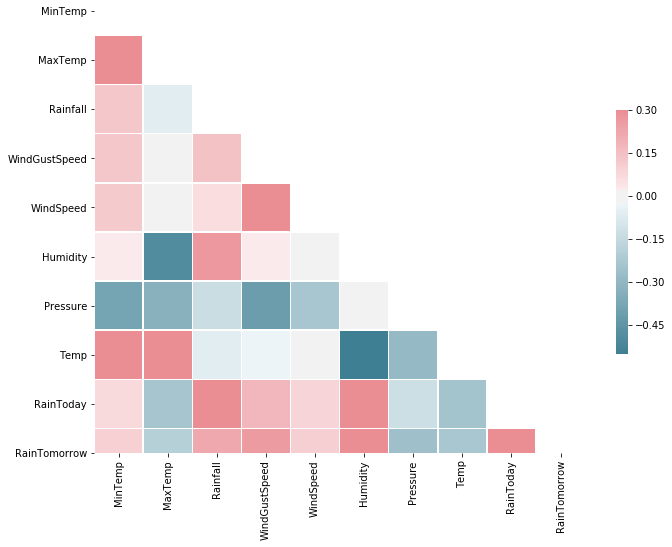

In [8]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Using the inferences from the correlation matrix, along with out finding from our missing values:
###### 1) WindSpeed does not have a high correlation with any of the features, hence imputing it with median of the values in the same location would be the the best option
###### 2) We can do the same with WindGustSpeed, but the issue is that the some locations do not have any reference. For cases like those, we can use linear regression to impute the values. Our dependent variables will be 'MinTemp','MaxTemp','Rainfall' & 'WindSpeed'.
###### 3) Feature Temp has high correlation with MinTemp and MaxTemp. Hence we can use them to impute the missing Temp values.
###### 4) Pressure has a large number of missing values. Although imputeing with the median of the feature can be done, another method could be to use the Ideal gas law. For places with no reference, we can use the median.
###### 5) Feature Humdity has as high correlation with 'Location','MinTemp','MaxTemp','Temp','WindGustSpeed' & 'RainToday'. Hence we can use Linear regression to impute the same 

##### Ideal gas Law:
$$
\frac{P_1}{T_1} = \frac{P_2}{T_2}
$$

In [9]:
#imputing Wind Gust Speed, Wind Speed

for l in df['Location'].unique():
    if(not df[df.Location==l].WindGustSpeed.isna().all()):
        v=df[df.Location==l].WindGustSpeed.median()
        df.loc[df.Location==l,'WindGustSpeed'] = df.loc[df.Location==l,'WindGustSpeed'].fillna(value=v)
    
    if(not df[df.Location==l].WindSpeed.isna().all()):
        v=df[df.Location==l].WindSpeed.median()
        df.loc[df.Location==l,'WindSpeed'] = df.loc[df.Location==l,'WindSpeed'].fillna(value=v)
        
#imputing Temp using Linear Regression

X=df.dropna()[['MinTemp','MaxTemp']]
y=df.dropna()['Temp']

lm_temp = LinearRegression().fit(X, y)

for i,r in df[df.Temp.isnull()].iterrows():
    df.loc[i,'Temp']=(round(lm_temp.predict(np.array(r[['MinTemp','MaxTemp']]).reshape(-1,2))[0],2))

In [10]:
# imputing Pressure

dict={}
for l in df['Location'].unique():
    if(not df[df.Location==l].Pressure.isna().all()):
        v=(df[df.Location==l].Pressure/df[df.Location==l].Temp).median()
        dict[l]=v
    else:
        dict[l]=0
        
v=df.Pressure.median()
for i,r in df[df.Pressure.isnull()].iterrows():
    if dict[r['Location']]>0:
        df.loc[i,'Pressure']=r['Temp']*dict[r['Location']]
    else:
        df.loc[i,'Pressure']=v

In [11]:
#imputing WindGustSpeed values using Linear Regression

X=df.dropna()[['MinTemp','MaxTemp','Rainfall','WindSpeed']]
X['MinTemp*WindSpeed']=X.MinTemp*X.WindSpeed
X['WindSpeed*WindSpeed']=X.WindSpeed*X.WindSpeed
X['MaxTemp*WindSpeed']=X.MaxTemp*X.WindSpeed
y=df.dropna()['WindGustSpeed']

lm_wind = LinearRegression().fit(X, y)


df2=df[['MinTemp','MaxTemp','Rainfall','WindSpeed','WindGustSpeed']]
df2['MinTemp*WindSpeed']=df2.MinTemp*df2.WindSpeed
df2['WindSpeed*WindSpeed']=df2.WindSpeed*df2.WindSpeed
df2['MaxTemp*WindSpeed']=df2.MaxTemp*df2.WindSpeed
df2=df2[df2.WindGustSpeed.isnull()].drop(['WindGustSpeed'], axis=1)


for i,r in df2.iterrows():
    df.loc[i,'WindGustSpeed']=(round(lm_wind.predict(np.array(r[:]).reshape(-1,7))[0],2))

C:\Users\sarth\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\sarth\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sarth\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [12]:
#imputing Humidity values using Linear Regression    

X=df.dropna()[['Location','MinTemp','MaxTemp','Temp','WindGustSpeed','RainToday']]
X = pd.get_dummies(X,columns=['Location'])
X['MinTemp*RainToday']=X.MinTemp*X.RainToday
X['MaxTemp*Temp']=X.MaxTemp*X.Temp
X['MaxTemp*RainToday']=X.MaxTemp*X.RainToday
X['WindGustSpeed*RainToday']=X.WindGustSpeed*X.RainToday
y=df.dropna()['Humidity']

lm_humid = LinearRegression().fit(X, y)


df2=df[['Location','MinTemp','MaxTemp','Temp','WindGustSpeed','RainToday','Humidity']]
df2 = pd.get_dummies(df2,columns=['Location'])
df2['MinTemp*RainToday']=df2.MinTemp*df2.RainToday
df2['MaxTemp*Temp']=df2.MaxTemp*df2.Temp
df2['MaxTemp*RainToday']=df2.MaxTemp*df2.RainToday
df2['WindGustSpeed*RainToday']=df2.WindGustSpeed*df2.RainToday
df2=df2[df2.Humidity.isnull()].drop(['Humidity'], axis=1)


for i,r in df2.iterrows():
    df.loc[i,'Humidity']=(round(lm_humid.predict(np.array(r[:]).reshape(-1,58))[0],2))

##### Checking the the data for missing values now. 

In [13]:
(df.isnull().sum()/df.shape[0])*100

Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir          0.0
WindSpeed        0.0
Humidity         0.0
Pressure         0.0
Temp             0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

In [14]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Temp,RainToday,RainTomorrow
0,NorahHead,18.9,23.7,0.0,SSE,41.0,SSE,28.0,55.0,1026.0,22.4,0,1
1,Nuriootpa,11.1,20.8,0.0,W,39.0,WSW,26.0,48.0,1014.4,19.5,0,0
2,GoldCoast,15.9,19.5,17.6,SE,44.0,SW,9.0,99.0,1028.5,17.8,1,1
3,Bendigo,0.0,14.9,0.0,WSW,35.0,WNW,19.0,55.0,1023.0,14.2,0,1
4,Walpole,9.1,22.7,0.0,NNE,41.0,ESE,7.0,40.0,1027.1,22.5,0,0


#### This data will now be used for our model analysis

### b) Data analysis

##### Before any analysis, lets make certain functions to make our analysis easier

In [15]:
# This function is used to cart bar plots for all categorical columns wrt RainTomorrow

def chartfunc(col):
    dist_data = pd.concat([df[df.RainTomorrow == 1].groupby(col)[col].count()
                     ,df[df.RainTomorrow == 0].groupby(col)[col].count()],axis=1)
    col1,col2 = (col+'_Yes'),(col+'_No')
    dist_data.columns = [(col+'_Yes'),(col+'_No')]
    
    dist_data_Yes = dist_data[col1]/(dist_data[col1]+dist_data[col2])
    
    dist_data_No = dist_data[col2]/(dist_data[col1]+dist_data[col2])
    
    x = np.arange(len(dist_data))
    width = 0.35

    mpl.style.use('tableau-colorblind10')
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.bar(x - width/2, dist_data_Yes, width, label='Yes',color='#1CAEE2')
    ax.bar(x + width/2, dist_data_No, width, label='No',color='#D4DC1A')
    
    ax.set_ylabel('Relative %age')
    ax.set_xlabel(col)
    ax.set_title('RainTomorrow by '+col)
    ax.set_xticks(x)
    ax.set_xticklabels(dist_data.index)
    ax.legend()
    
    fig.tight_layout()
    plt.show()

In [16]:
# This function is used to cart histograms and box plots for all numerical columns

def numplot(col):
    fig, ax = plt.subplots(figsize=(12, 3))
    mpl.style.use('tableau-colorblind10')
    plt.subplot(1,2,1)
    plt.hist(df[col],range=(df[col].min(), df[col].max()),color='green')
    plt.xlabel('Range')
    plt.ylabel('Frequency')
    plt.title(col)
    
    plt.subplot(1,2,2)
    plt.boxplot(df[col],vert=False)
    
    plt.show()

### Checking the Numerical variables

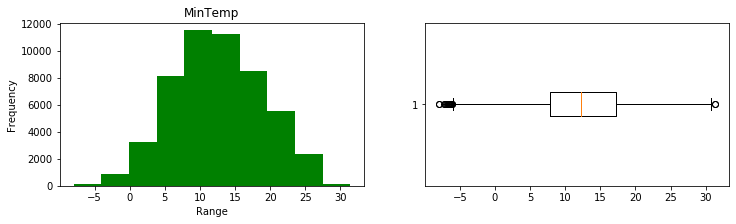

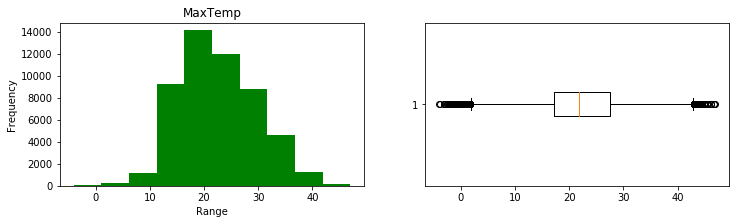

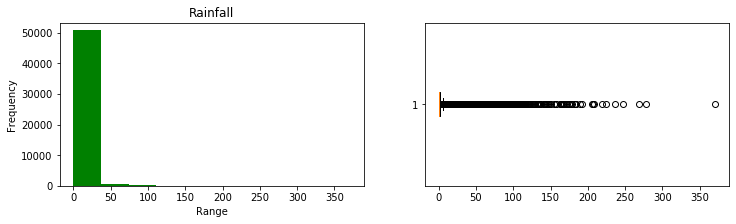

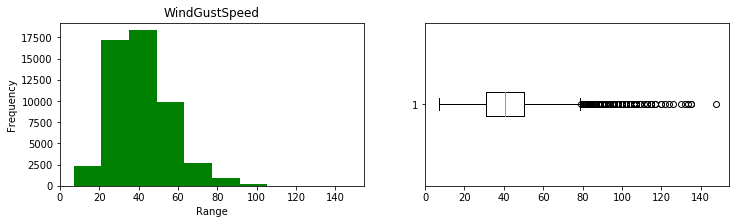

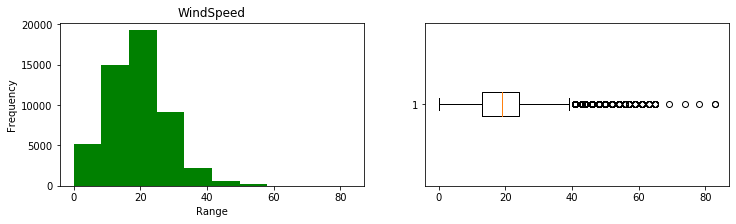

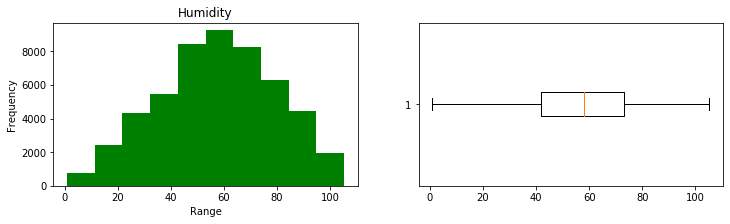

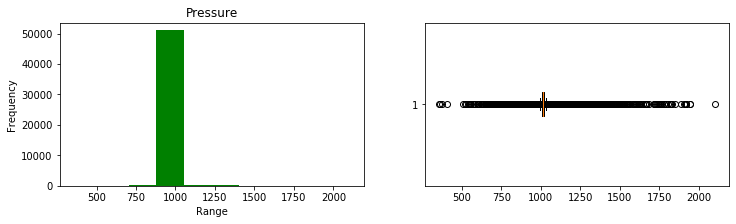

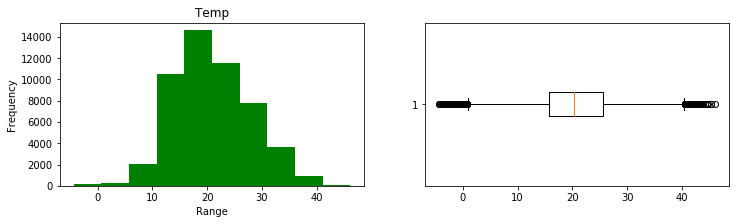

In [17]:
for columns in ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed','Humidity','Pressure','Temp']:
    numplot(columns)

##### We can observe that almost almost all the numerical columns have outliers. However, Given their number and ligitimacy, we dont want to loose information they preserve about their entry. We also want to preserve the sturcture of the distribution. 

##### This information is necessary to determine how we will be scaling the data. Incase of Descision Tree, scaling the value is not required. However for Clustering, values have to be scaled to get the optimal readings. Keeping the points mentioned before in mind, we will use MinMaxScaler to scale the values when clustering.

### Checking the Categorical variables

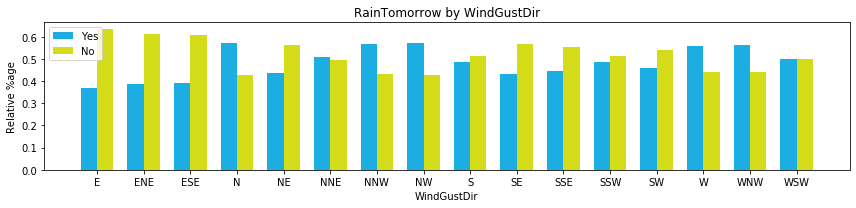

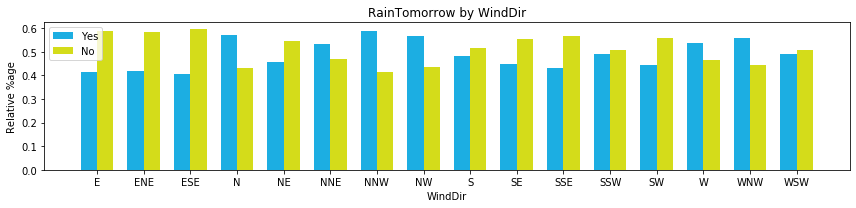

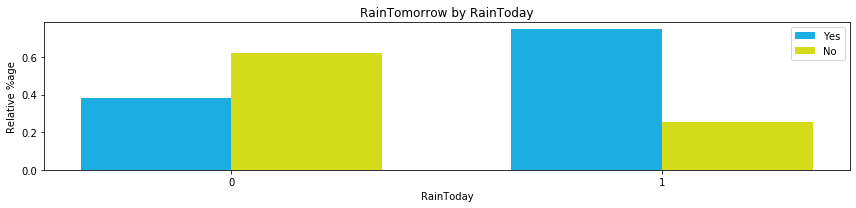

In [18]:
for columns in ['WindGustDir','WindDir','RainToday']:
    chartfunc(columns)

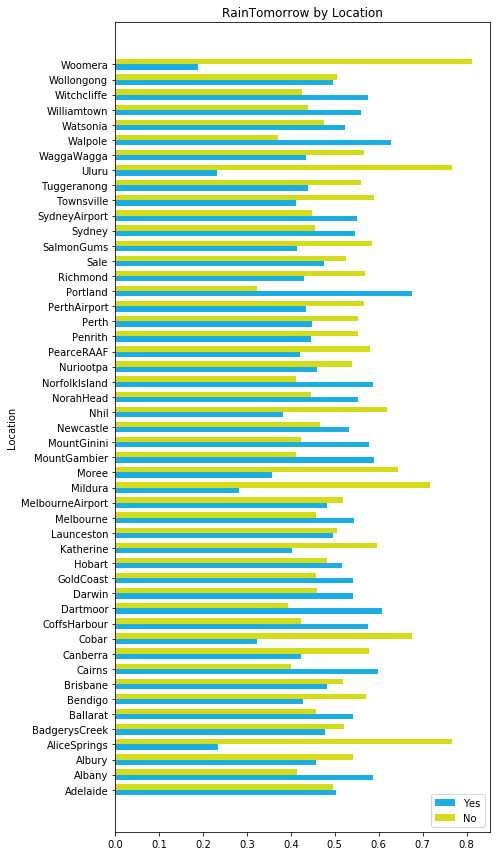

In [19]:
    col="Location"
    
    dist_data = pd.concat([df[df.RainTomorrow == 1].groupby(col)[col].count()
                     ,df[df.RainTomorrow == 0].groupby(col)[col].count()],axis=1)
    col1,col2 = (col+'_Yes'),(col+'_No')
    dist_data.columns = [(col+'_Yes'),(col+'_No')]
    
    dist_data_Yes = dist_data[col1]/(dist_data[col1]+dist_data[col2])
    
    dist_data_No = dist_data[col2]/(dist_data[col1]+dist_data[col2])
    
    x = np.arange(len(dist_data))
    width = 0.35

    mpl.style.use('tableau-colorblind10')
    fig, ax = plt.subplots(figsize=(7, 12))
    ax.barh(x - width/2, dist_data_Yes, width, label='Yes',color='#1CAEE2')
    ax.barh(x + width/2, dist_data_No, width, label='No',color='#D4DC1A')
    
    ax.set_ylabel('Relative %age')
    ax.set_ylabel(col)
    ax.set_title('RainTomorrow by '+col)
    ax.set_yticks(x)
    ax.set_yticklabels(dist_data.index)
    ax.legend()
    
    fig.tight_layout()
    plt.show()

##### We can observe that apart from RainToday, the categorical variables the results are pretty mixed. There is no distinguishing factor for RainTomorrow for any of the categorical variables. We can therefore assume that the importance of these will be lower.

## Step 2: Building & Tuning Models
#### Before moving to model tuning, we need to set up the scoring parameter we are using to fine tune the model. In case of predicting if it's going to rain or not, we need to reduce the false negatives we need to correctly predict when its going to rain and reduce the chances of incorrectly predciting when it will not rain. Hence the best metric(s) to do that would be use recall and precision.   

### a) KMeans Clustering
#### KMeans clustering involves using the numerical data to create clusters which can then be used to predict unlabelled data in the future. It is a form of unsupervised learning which does not require y features to be labelled or categorised.

#### As mentioned earlier, categorical variables are low in the order of feature importance. Also including them as dummy variables will disrupt the centroid of the model as dummy variable are not discrete. Hence we will only use numerical variables.

#### Since features MaxTemp and Temp have high multicollinearity, hence having both is not necessary.

##### Before we do any predictions, we need to find the optimal number of clusters.

In [20]:
# Creating a new df for KMeans clustering 
cluster_df = df[['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed','Humidity','Pressure','RainTomorrow']]
cluster_df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed,Humidity,Pressure,RainTomorrow
0,18.9,23.7,0.0,41.0,28.0,55.0,1026.0,1
1,11.1,20.8,0.0,39.0,26.0,48.0,1014.4,0
2,15.9,19.5,17.6,44.0,9.0,99.0,1028.5,1
3,0.0,14.9,0.0,35.0,19.0,55.0,1023.0,1
4,9.1,22.7,0.0,41.0,7.0,40.0,1027.1,0


##### As mentioned earlier, we need to scale the data using  MinMaxScaler

In [21]:
from sklearn.preprocessing import MinMaxScaler
# Scaling the data 

scalar = MinMaxScaler()
cluster_scaled = scalar.fit_transform(cluster_df[cluster_df.columns[:-1]])
cluster_scaled

array([[0.68274112, 0.54403131, 0.        , ..., 0.3373494 , 0.51863235,
        0.38378562],
       [0.48477157, 0.48727984, 0.        , ..., 0.31325301, 0.45140223,
        0.37716425],
       [0.60659898, 0.46183953, 0.04743935, ..., 0.10843373, 0.94122167,
        0.38521264],
       ...,
       [0.48477157, 0.41682975, 0.0032345 , ..., 0.13253012, 0.87399155,
        0.37961872],
       [0.68527919, 0.56555773, 0.        , ..., 0.20481928, 0.61467537,
        0.37773506],
       [0.75126904, 0.78864971, 0.        , ..., 0.08433735, 0.44179793,
        0.37231238]])

##### To find the optimal number of clusters, we need to plot the elbow curve between a range of k values 

In [22]:
from sklearn.cluster import KMeans
#Running Kmeans for k values between 1 and 10

kmeans = [KMeans(n_clusters=k, random_state=42).fit(cluster_scaled) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans]

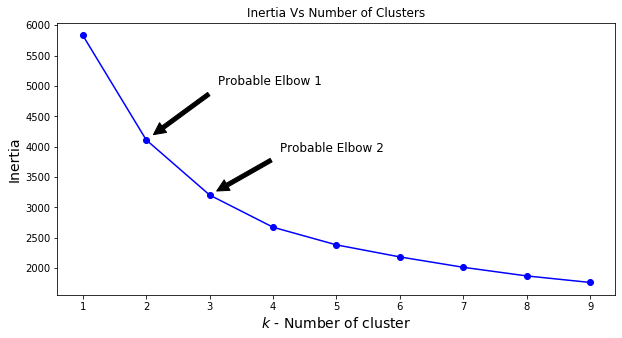

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1,10),inertias,'bo-')
plt.xlabel("$k$ - Number of cluster", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Probable Elbow 1',xy=(2, inertias[1]),xytext=(0.35, 0.75),textcoords='figure fraction',fontsize=12,arrowprops={'facecolor':'black', 'shrink':0.1})
plt.annotate('Probable Elbow 2',xy=(3, inertias[2]),xytext=(0.45, 0.55),textcoords='figure fraction',fontsize=12,arrowprops={'facecolor':'black', 'shrink':0.1})
plt.title("Inertia Vs Number of Clusters")
plt.show();

##### Looking at the elbow score we cannot finalize any clear cut k value to finally run on our prediction model. As evident from the plot, both k value 2 and 3 seem optimal. Hence we will have to do further analysis to finalize out k value. 

##### Lets see if a Silhouette Score plot can provide us with any concrete values. which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster).

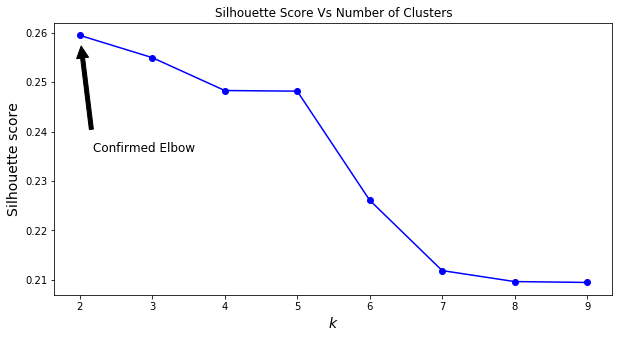

In [24]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(cluster_scaled, model.labels_) for model in kmeans[1:]]
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.annotate('Confirmed Elbow',xy=(2, silhouette_scores[0]),xytext=(0.15, 0.55),textcoords='figure fraction',fontsize=12,arrowprops={'facecolor':'black', 'shrink':0.1})
plt.title("Silhouette Score Vs Number of Clusters")
plt.show()

##### As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=2$ is a very good choice, but it also underlines the fact that $k=3$ is quite good as well

##### Now that the number of clusters are finalized, we can start running the KMeans model to optimize and predict our values 

In [25]:
from sklearn.model_selection import train_test_split
#Splitting to training and testing

X_train, X_test, y_train, y_test = train_test_split(cluster_df[cluster_df.columns[:-1]],cluster_df['RainTomorrow'],test_size=0.3,random_state=1)

In [26]:
# Scaling the training data

X_train_scaled = scalar.fit_transform(X_train)

In [27]:
# Running Vanilla Kmeans on training data

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
# Scaling the testing data and predicting 

X_test_scaled = scalar.fit_transform(X_test)
pred=kmeans.predict(X_test_scaled)

In [29]:
from sklearn import metrics
# checking the model score

print("Precision - ",round(metrics.precision_score(y_test,pred)*100,2))
print("Recall - ",round(metrics.recall_score(y_test,pred)*100,2))
print("F1 Score - ",round(metrics.f1_score(y_test,pred)*100,2))

Precision -  64.24
Recall -  74.94
F1 Score -  69.17


In [30]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65      7924
           1       0.64      0.75      0.69      7557

    accuracy                           0.67     15481
   macro avg       0.68      0.68      0.67     15481
weighted avg       0.68      0.67      0.67     15481



##### As you can see, the model performs very poorly on default settings. We will therefore have to run Grid Search on the model to get the optimal performance

In [31]:
from sklearn.model_selection import GridSearchCV

#Running Grid Search on recall 

param_grid = {'init':['k-means++', 'random'],
              'random_state':[None,0,42],
              'n_init':list(range(8,15)),
              'max_iter':list(range(100,300,50))
             }

grid = GridSearchCV(kmeans, param_grid, verbose=1, scoring='recall')

In [32]:
#grid.fit(X_train_scaled,y_train)

In [33]:
#grid.best_params_

In [34]:
#grid.best_score_

##### Now that we have the best hyper parameters, we can use use them to run our model.

In [35]:
# Running Kmeans again with the optamized model

kmeans_final = KMeans(n_clusters=2, random_state=42,algorithm='auto',init='k-means++',precompute_distances='auto',max_iter=100,n_init=11)
kmeans_final.fit(X_train_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=11, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [36]:
# Predicting the values and checking performance

pred=kmeans_final.predict(X_test_scaled)
print("Precision - ",round(metrics.precision_score(y_test,pred)*100,2))
print("Recall - ",round(metrics.recall_score(y_test,pred)*100,2))
print("F1 Score - ",round(metrics.f1_score(y_test,pred)*100,2))
print("Accuracy - ",round(metrics.accuracy_score(y_test,pred)*100,2))

Precision -  64.34
Recall -  75.15
F1 Score -  69.32
Accuracy -  67.53


##### As you can see, the model has drastically imporved their performance after using the best hyperparameters

In [38]:
# doing PCA Plotting for the test data 

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test_scaled)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['predicted']=pred

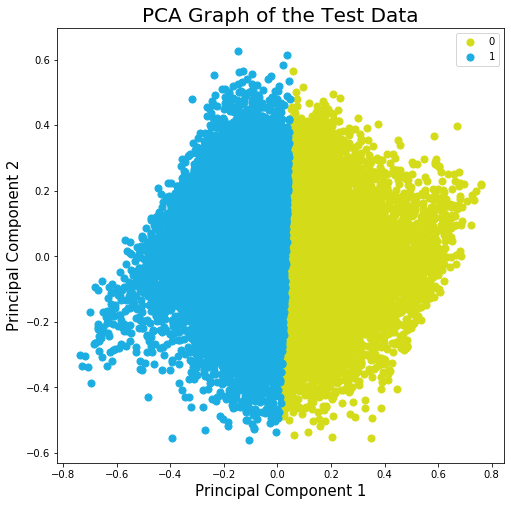

In [102]:
mpl.style.use('tableau-colorblind10')
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Graph of the Test Data', fontsize = 20)
targets = [0, 1]
colors = ['#D4DC1A', '#1CAEE2']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['predicted'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'], principalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
plt.show();

##### Plotting the PCA graph shows how the data has been distirbuted  by the Kmeans object

### b) Decision Tree

##### For The Decision tree, we will need to convert all the dummy variables to numerical variables. 

In [40]:
# Creating dummy variables
tree_df=pd.get_dummies(df,columns=['Location','WindGustDir','WindDir','RainToday'])

In [41]:
tree_df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed,Humidity,Pressure,Temp,RainTomorrow,Location_Adelaide,...,WindDir_S,WindDir_SE,WindDir_SSE,WindDir_SSW,WindDir_SW,WindDir_W,WindDir_WNW,WindDir_WSW,RainToday_0,RainToday_1
0,18.9,23.7,0.0,41.0,28.0,55.0,1026.0,22.4,1,0,...,0,0,1,0,0,0,0,0,1,0
1,11.1,20.8,0.0,39.0,26.0,48.0,1014.4,19.5,0,0,...,0,0,0,0,0,0,0,1,1,0
2,15.9,19.5,17.6,44.0,9.0,99.0,1028.5,17.8,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0.0,14.9,0.0,35.0,19.0,55.0,1023.0,14.2,1,0,...,0,0,0,0,0,0,1,0,1,0
4,9.1,22.7,0.0,41.0,7.0,40.0,1027.1,22.5,0,0,...,0,0,0,0,0,0,0,0,1,0


##### Now that we have created the dataframe with dummy variables, we can run and optamize the model.

In [42]:
#seperating the dependent and independent variables
tree_df_labels = tree_df['RainTomorrow'].copy()
tree_df = tree_df.drop(['RainTomorrow','Temp'], axis=1)

In [43]:
from sklearn.model_selection import train_test_split
#Splitting to training and testing
X_train, X_test, y_train, y_test = train_test_split(tree_df,tree_df_labels,test_size=0.3,random_state=1)

In [44]:
from sklearn.tree import DecisionTreeClassifier
#Running the tree classifier in Vanilla settings 
clf= DecisionTreeClassifier()

In [45]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [46]:
#Predicting the test data and checking performance
pred = clf.predict(X_test)
print("Precision - ",round(metrics.precision_score(y_test,pred)*100,2))
print("Recall - ",round(metrics.recall_score(y_test,pred)*100,2))
print("F1 Score - ",round(metrics.f1_score(y_test,pred)*100,2))
print("Accuracy - ",round(metrics.accuracy_score(y_test,pred)*100,2))

Precision -  71.14
Recall -  71.52
F1 Score -  71.33
Accuracy -  71.93


##### As you can see, compared to kmeans, the model perform pretty well, however we can tweek around wi the hyperparameters to improve the performance even further.

In [47]:
#Using GridSearch to optimize performance
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': list(range(5,15)),
              'max_leaf_nodes': list(range(20,31))}

grid = GridSearchCV(clf, param_grid, cv=8, verbose=1, scoring='recall')

In [48]:
#grid.fit(X_train_scaled,y_train)

In [49]:
#grid.best_params_

In [50]:
#grid.best_score_

##### Now that we have the best hyperparameters, we can create our final descision tree with them to achieve optimal performance

In [51]:
clf_final = DecisionTreeClassifier(criterion='entropy', max_depth=6,max_leaf_nodes=20,min_samples_leaf=1,min_samples_split=2)

In [52]:
clf_final.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [53]:
pred = clf_final.predict(X_test)
print("Precision - ",round(metrics.precision_score(y_test,pred)*100,2))
print("Recall - ",round(metrics.recall_score(y_test,pred)*100,2))
print("F1 Score - ",round(metrics.f1_score(y_test,pred)*100,2))
print("Accuracy - ",round(metrics.accuracy_score(y_test,pred)*100,2))

Precision -  73.68
Recall -  77.21
F1 Score -  75.41
Accuracy -  75.42


##### This is definately an improvement over the tree classifier in its vanilla settings.

##### We can also see by plotting the most importance features that the numerical features have higher importance than categorical ones.

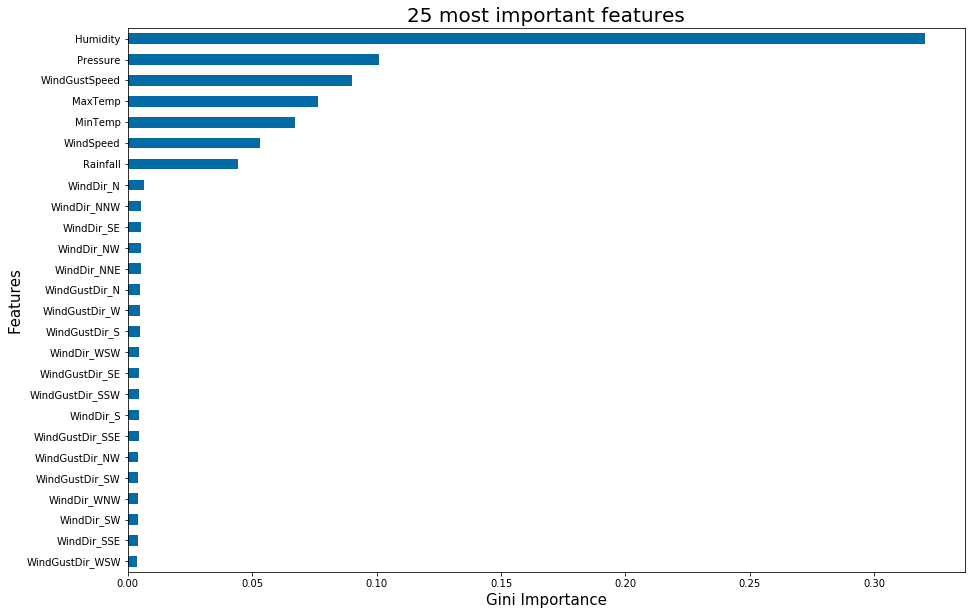

In [54]:
model_ranks = pd.Series(clf.feature_importances_, index=X_train.columns, name='Importance')
model_ranks.sort_values(ascending=True,inplace=True)
top_features = model_ranks[-26:]
plt.figure(figsize=(15,10))
ax = top_features.plot(kind='barh')
ax.set_xlabel('Gini Importance', fontsize = 15)
ax.set_ylabel('Features', fontsize = 15)
ax.set_title('25 most important features', fontsize = 20)
plt.show();

##### Lets plot the  ROC curve for our final model

AUC Score -  83.39


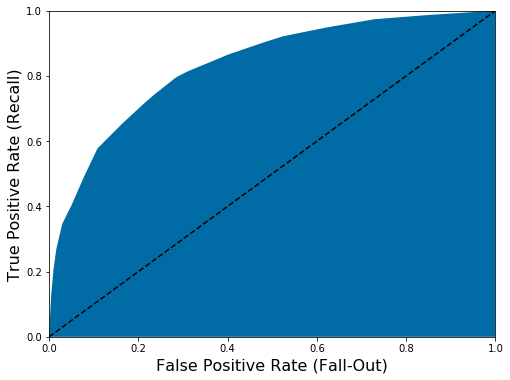

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Calculating the AUC Score and plotting the ROC curve

pred_prob = clf_final.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test,pred_prob[:,1])
print("AUC Score - ", round(roc_auc_score(y_test,pred_prob[:,1])*100,2))
def plot_roc_curve(fpr, tpr, label=None):
    plt.fill_between(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)                                               

plt.figure(figsize=(8, 6))                      
plot_roc_curve(fpr, tpr)

plt.show()

##### As you can see, the AUC score is pretty good for the model

##### Plotting the Tree vizualisation

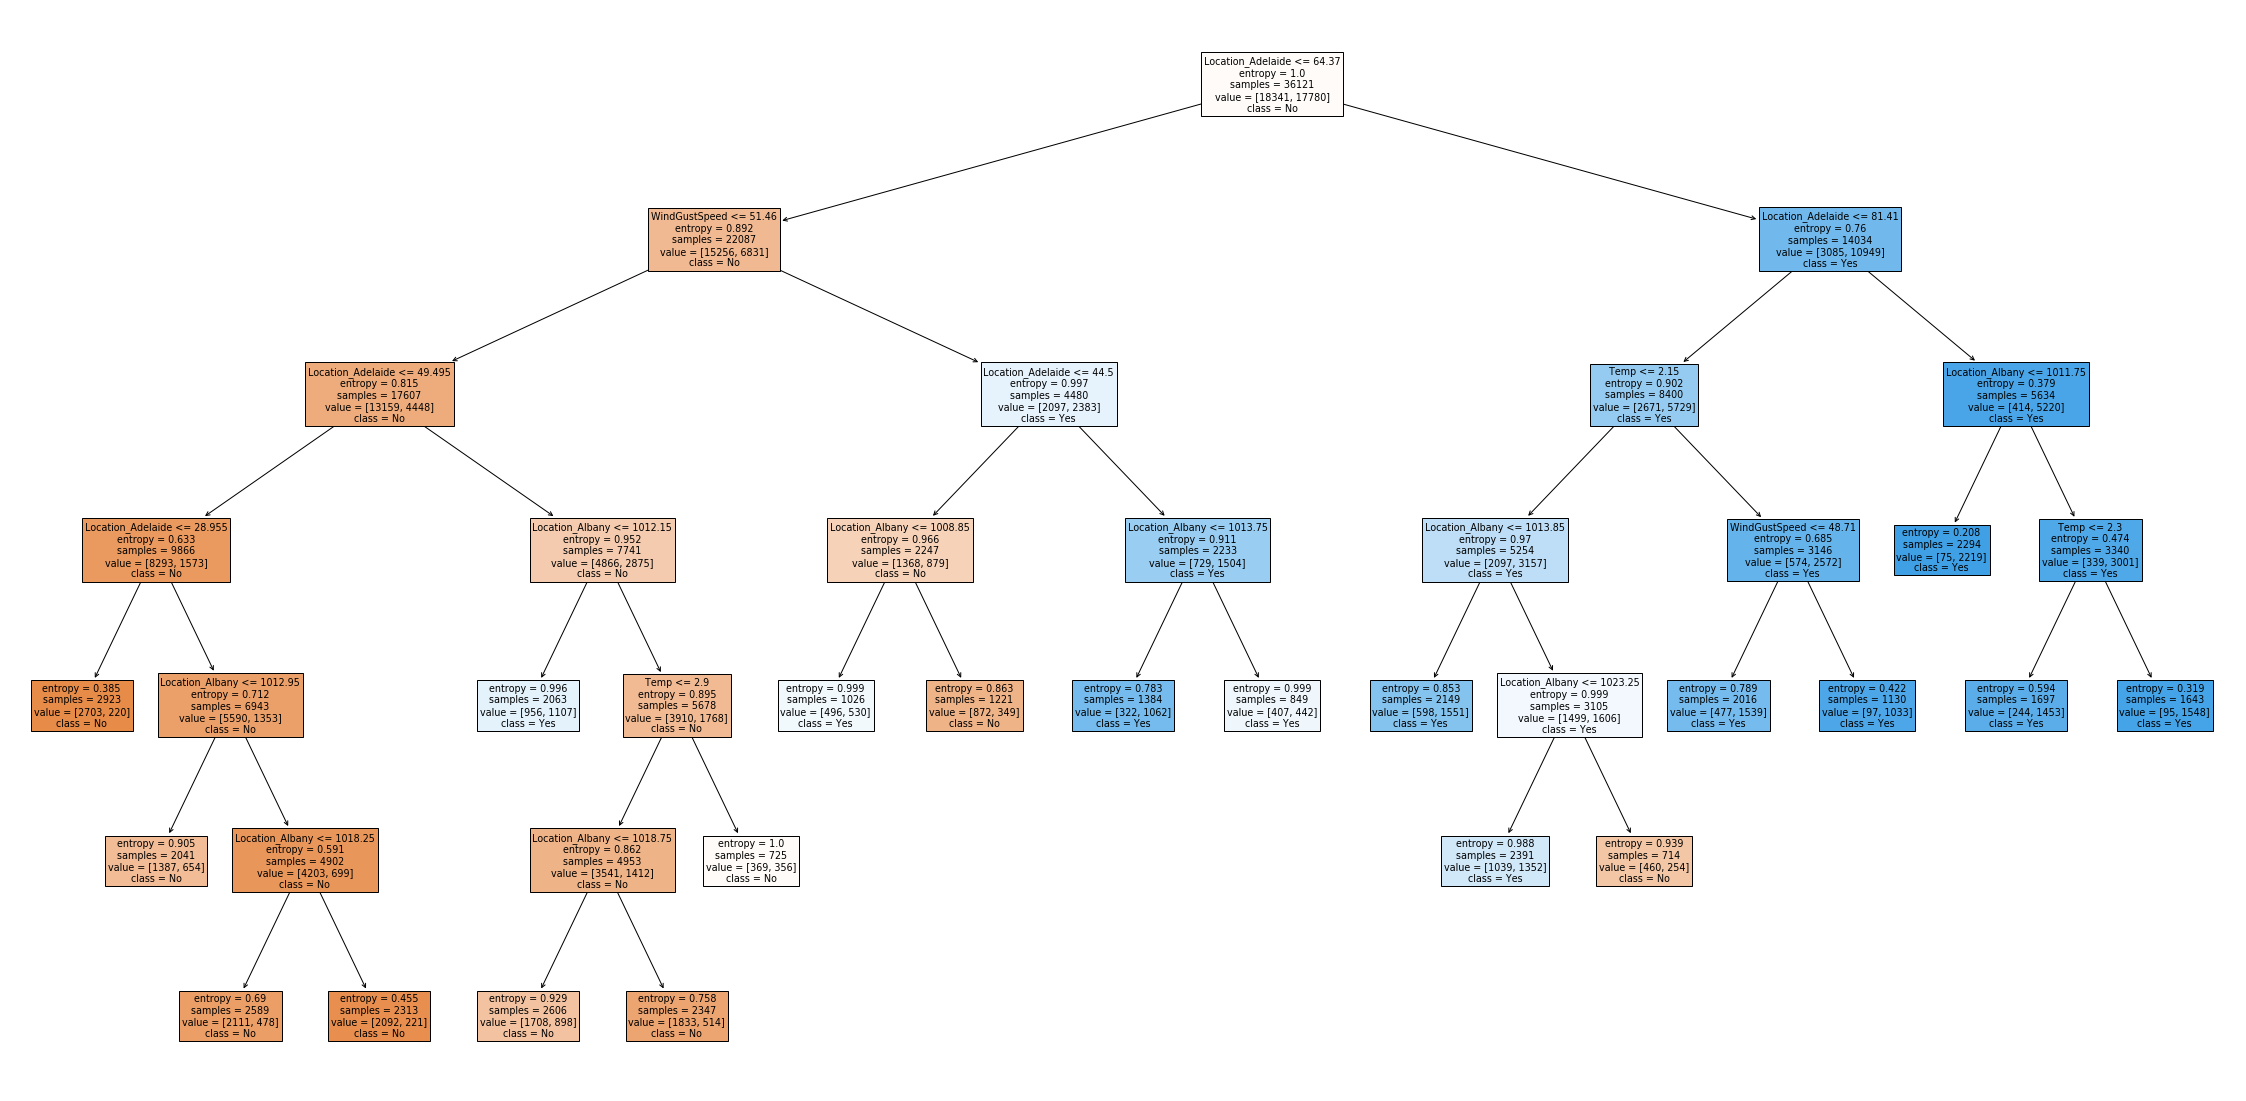

In [56]:
from sklearn.tree import plot_tree

plt.figure(figsize=(40,20))
plot_tree(clf_final,filled=True,feature_names=X.columns,class_names=['No','Yes'])
plt.show()

### c) HAC Clustering
#### Note: Due to the high computation requirements of thsi model, this section of the code has been implements and run on the cloud with the screen shots of the output, performance metrics and graphs pasted here. Additionally, the code here is commented in case the evaluator decides to run the code 

In [57]:
from sklearn.cluster import AgglomerativeClustering

##### From our analysis of KMeans, we know that the optimal number of clusters to use is 2.

In [ ]:
HAC = AgglomerativeClustering(n_clusters=2)
#HAC.fit_predict(X_test_scaled)

In [ ]:
#Running the model and comparing the initial performance
#pred=HAC.labels_
'''
print("Precision - ",round(metrics.precision_score(y_test,pred)*100,2))
print("Recall - ",round(metrics.recall_score(y_test,pred)*100,2))
print("F1 Score - ",round(metrics.f1_score(y_test,pred)*100,2))
print("Accuracy - ",round(metrics.accuracy_score(y_test,pred)*100,2))
'''

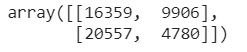

##### After running HAC model, we can see that the model performnace is pretty bad. However upon further analysis, it was concluded that the predictor was classifying inversely compared to the actual values

##### We can therefore inverse the predicted values so that the predictor and the actual values match.

In [ ]:
#pred=1-HAC.labels_
'''
print("Precision - ",round(metrics.precision_score(y_test,pred)*100,2))
print("Recall - ",round(metrics.recall_score(y_test,pred)*100,2))
print("F1 Score - ",round(metrics.f1_score(y_test,pred)*100,2))
print("Accuracy - ",round(metrics.accuracy_score(y_test,pred)*100,2))
'''

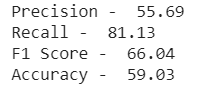

##### Now the predicted values align, which is reflected in the performance of the model.

##### We can now plot Dendogram for the HAC and see how many clusters does it actualy make when allowed to run

In [ ]:
#Function to plot the dendograms
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
                                      
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
'''
cluster= AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X_test_scaled)
plt.figure(figsize=(15,10))
plot_dendrogram(cluster, truncate_mode='level', p=3)
plt.axhline(y=45)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show();
'''

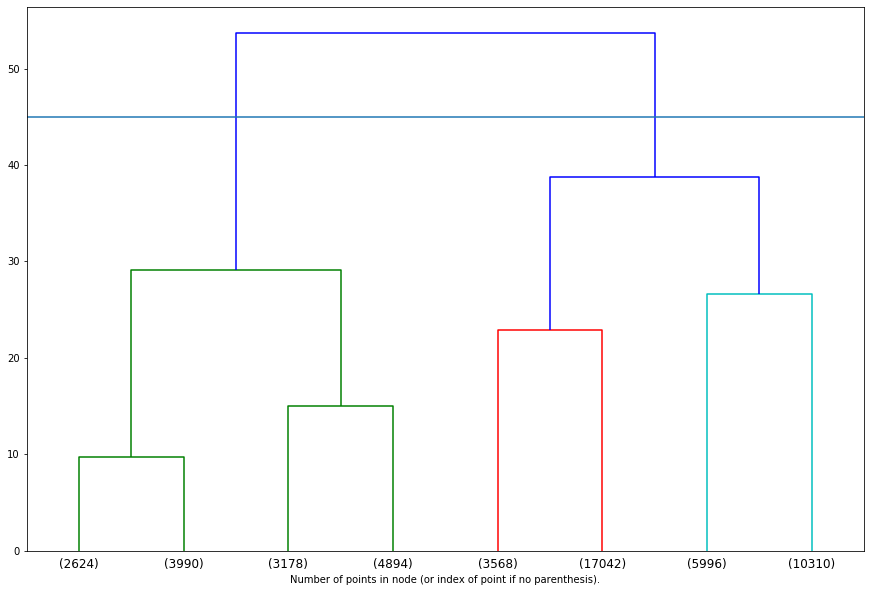

##### We can see that when allowed to run completely, the model makes 8 clusters.

## Step 3: Prediction and Interpretation
### a) Data Cleaning

In [58]:
df_test = pd.read_csv('Weather Forecast Testing.csv')
df_test.head()

,ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday
0,1,Perth,15.3,21.5,4.4,2.4,1.4,NW,70.0,W,22.0,69.0,997.6,7.0,19.8,Yes
1,2,Portland,7.1,11.0,38.8,1.2,5.8,SSE,48.0,SW,19.0,46.0,1014.0,4.0,10.7,Yes
2,3,Hobart,3.6,16.6,0.2,2.8,9.3,NW,37.0,N,15.0,48.0,1016.6,5.0,15.4,No
3,4,Woomera,17.6,37.4,0.0,34.0,NaN,NNW,37.0,NW,19.0,11.0,1010.4,2.0,34.6,No
4,5,Townsville,11.4,25.6,0.0,6.0,2.8,ESE,31.0,SSE,13.0,52.0,1016.4,7.0,24.3,No


In [59]:
(df_test.isnull().sum()/df_test.shape[0])*100

ID                0.000000
Location          0.000000
MinTemp           0.361705
MaxTemp           0.138525
Rainfall          1.239033
Evaporation      42.450362
Sunshine         46.898569
WindGustDir       7.149454
WindGustSpeed     7.080191
WindDir           2.978298
WindSpeed         2.008619
Humidity          2.685855
Pressure          9.950746
Cloud            38.633215
Temp              2.054795
RainToday         1.239033
dtype: float64

In [60]:
#drop columns
df_test.drop(['Evaporation','Sunshine','Cloud'],inplace=True,axis=1)  

#drop na rows in MinTemp, MaxTemp
df_test.dropna(subset=['MinTemp','MaxTemp'],how='any',inplace=True)

#fillNa and Mapping
df_test.RainToday.fillna(value='No',inplace=True)
map={'Yes':1,'No':0}
df_test.RainToday=[map[item] for item in df_test.RainToday]

#imputing Rainfall
df_test.Rainfall.fillna(value=0.0,inplace=True)

#imputing WindGustDir

for l in df_test['Location'].unique():
    if (not df_test[df_test.Location==l].WindGustDir.isna().all()):
        v=(df_test[df_test.Location==l].WindGustDir.mode()[0])
        df_test.loc[df_test.Location==l,'WindGustDir'] = df_test.loc[df_test.Location==l,'WindGustDir'].fillna(value=v)
    else:
        v=df_test.WindGustDir.mode()[0]
        df_test.loc[df_test.Location==l,'WindGustDir'] = df_test.loc[df_test.Location==l,'WindGustDir'].fillna(value=v)

#imputing WindDir

for l in df_test['Location'].unique():
    if (not df_test[df_test.Location==l].WindDir.isna().all()):
        v=(df_test[df_test.Location==l].WindDir.mode()[0])
        df_test.loc[df_test.Location==l,'WindDir'] = df_test.loc[df_test.Location==l,'WindDir'].fillna(value=v)
    else:
        v=df_test.WindDir.mode[0]
        df_test.loc[df_test.Location==l,'WindDir'] = df_test.loc[df_test.Location==l,'WindDir'].fillna(value=v)

In [61]:
#imputing Wind Gust Speed, Wind Speed

for l in df_test['Location'].unique():
    if(not df_test[df_test.Location==l].WindGustSpeed.isna().all()):
        v=df_test[df_test.Location==l].WindGustSpeed.median()
        df_test.loc[df_test.Location==l,'WindGustSpeed'] = df_test.loc[df_test.Location==l,'WindGustSpeed'].fillna(value=v)
    
    if(not df_test[df_test.Location==l].WindSpeed.isna().all()):
        v=df_test[df_test.Location==l].WindSpeed.median()
        df_test.loc[df_test.Location==l,'WindSpeed'] = df_test.loc[df_test.Location==l,'WindSpeed'].fillna(value=v)

for i,r in df_test[df_test.Temp.isnull()].iterrows():
    df_test.loc[i,'Temp']=(round(lm_temp.predict(np.array(r[['MinTemp','MaxTemp']]).reshape(-1,2))[0],2))

In [62]:
v=df_test.Pressure.median()
for i,r in df_test[df_test.Pressure.isnull()].iterrows():
    if dict[r['Location']]>0:
        df_test.loc[i,'Pressure']=r['Temp']*dict[r['Location']]
    else:
        df_test.loc[i,'Pressure']=v

In [63]:
df2=df_test[['MinTemp','MaxTemp','Rainfall','WindSpeed','WindGustSpeed']]
df2['MinTemp*WindSpeed']=df2.MinTemp*df2.WindSpeed
df2['WindSpeed*WindSpeed']=df2.WindSpeed*df2.WindSpeed
df2['MaxTemp*WindSpeed']=df2.MaxTemp*df2.WindSpeed
df2=df2[df2.WindGustSpeed.isnull()].drop(['WindGustSpeed'], axis=1)


for i,r in df2.iterrows():
    df_test.loc[i,'WindGustSpeed']=(round(lm_wind.predict(np.array(r[:]).reshape(-1,7))[0],2))

C:\Users\sarth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sarth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sarth\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [64]:
df2=df_test[['Location','MinTemp','MaxTemp','Temp','WindGustSpeed','RainToday','Humidity']]
df2 = pd.get_dummies(df2,columns=['Location'])
df2['MinTemp*RainToday']=df2.MinTemp*df2.RainToday
df2['MaxTemp*Temp']=df2.MaxTemp*df2.Temp
df2['MaxTemp*RainToday']=df2.MaxTemp*df2.RainToday
df2['WindGustSpeed*RainToday']=df2.WindGustSpeed*df2.RainToday
df2=df2[df2.Humidity.isnull()].drop(['Humidity'], axis=1)


for i,r in df2.iterrows():
    df_test.loc[i,'Humidity']=(round(lm_humid.predict(np.array(r[:]).reshape(-1,58))[0],2))

In [65]:
(df_test.isnull().sum()/df_test.shape[0])*100

ID               0.0
Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir          0.0
WindSpeed        0.0
Humidity         0.0
Pressure         0.0
Temp             0.0
RainToday        0.0
dtype: float64

In [66]:
df_test.head()

,ID,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Temp,RainToday
0,1,Perth,15.3,21.5,4.4,NW,70.0,W,22.0,69.0,997.6,19.8,1
1,2,Portland,7.1,11.0,38.8,SSE,48.0,SW,19.0,46.0,1014.0,10.7,1
2,3,Hobart,3.6,16.6,0.2,NW,37.0,N,15.0,48.0,1016.6,15.4,0
3,4,Woomera,17.6,37.4,0.0,NNW,37.0,NW,19.0,11.0,1010.4,34.6,0
4,5,Townsville,11.4,25.6,0.0,ESE,31.0,SSE,13.0,52.0,1016.4,24.3,0


In [67]:
#df_test.to_pickle("df_test")

In [68]:
# Tranforming the test df for Kmeans cluster
cluster_df = df_test[['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed','Humidity','Pressure']]
cluster_df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed,Humidity,Pressure
0,15.3,21.5,4.4,70.0,22.0,69.0,997.6
1,7.1,11.0,38.8,48.0,19.0,46.0,1014.0
2,3.6,16.6,0.2,37.0,15.0,48.0,1016.6
3,17.6,37.4,0.0,37.0,19.0,11.0,1010.4
4,11.4,25.6,0.0,31.0,13.0,52.0,1016.4


In [69]:
cluster_scaled = scalar.fit_transform(cluster_df)
cluster_scaled

array([[6.02209945e-01, 4.98023715e-01, 1.19695321e-02, ...,
        2.52873563e-01, 6.62897251e-01, 3.66455417e-01],
       [3.75690608e-01, 2.90513834e-01, 1.05549510e-01, ...,
        2.18390805e-01, 4.38682004e-01, 3.79392724e-01],
       [2.79005525e-01, 4.01185771e-01, 5.44069641e-04, ...,
        1.72413793e-01, 4.58178982e-01, 3.81443760e-01],
       ...,
       [4.66850829e-01, 4.76284585e-01, 0.00000000e+00, ...,
        2.98850575e-01, 4.28933515e-01, 3.78840522e-01],
       [3.89502762e-01, 4.74308300e-01, 2.72034820e-03, ...,
        2.29885057e-01, 4.48430493e-01, 3.84362543e-01],
       [6.07734807e-01, 4.72332016e-01, 1.94776931e-01, ...,
        1.95402299e-01, 6.14154806e-01, 3.76395055e-01]])

In [70]:
#predicting the target values using Kmeans
pred_cluster=kmeans_final.predict(cluster_scaled)

In [71]:
#Transforming the training df for Decision Tree Classifier
tree_df = pd.get_dummies(df_test.drop(['ID','Temp'],axis=1)  ,columns=['Location','WindGustDir','WindDir','RainToday'])
tree_df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed,Humidity,Pressure,Location_Adelaide,Location_Albany,Location_Albury,...,WindDir_S,WindDir_SE,WindDir_SSE,WindDir_SSW,WindDir_SW,WindDir_W,WindDir_WNW,WindDir_WSW,RainToday_0,RainToday_1
0,15.3,21.5,4.4,70.0,22.0,69.0,997.6,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,7.1,11.0,38.8,48.0,19.0,46.0,1014.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,3.6,16.6,0.2,37.0,15.0,48.0,1016.6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,17.6,37.4,0.0,37.0,19.0,11.0,1010.4,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,11.4,25.6,0.0,31.0,13.0,52.0,1016.4,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [72]:
#predicting the target values using Decision Tree
pred_tree=clf_final.predict(tree_df)

In [73]:
hac_df=cluster_scaled

In [74]:
#Using the scaled test values from Kmeans for HAC
HAC = AgglomerativeClustering(n_clusters=2)
#predicting the target values using HAC
pred_hac = HAC.fit_predict(cluster_scaled)

In [82]:
#Creating the prediction Dataframe
pred_df=pd.DataFrame({'ID':df_test['ID'],'KMeans':pred_cluster,'Decision Tree':pred_tree,'HAC':1-pred_hac})

In [88]:
pred_df.head()

,ID,KMeans,Decision Tree,HAC
0,1,Yes,Yes,Yes
1,2,Yes,No,Yes
2,3,Yes,No,Yes
3,4,No,No,No
4,5,No,No,Yes


In [84]:
def bin_map(x):
    if x==0:
        return 'No'
    else:
        return 'Yes'

In [87]:
#Mapping the value to change the predcitions from 0 and 1 to No and Yes
pred_df.KMeans=pred_df.KMeans.apply(bin_map)
pred_df['Decision Tree']=pred_df['Decision Tree'].apply(bin_map)
pred_df.HAC=pred_df.HAC.apply(bin_map)

In [89]:
pred_df.to_csv('Predictions.csv')

## Conclusions

#### 1) Comparing the Recall, Precision and the F1 score of the models, we can conclude that Decision tree is the best classifier among the three.
#### 2) For clustering, although the number of cluster is 2, we can use more number of clusters to group them further for better predictions.